In [92]:
import numpy as np
import cv2
from pandas import DataFrame, read_csv
from matplotlib import pyplot as plt
from shutil import copy2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Dense, Activation, Input, Conv2D, MaxPooling2D, Flatten,
                                     GlobalMaxPooling2D, LeakyReLU, Concatenate, Dropout)
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Nadam, Adamax
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from os.path import isfile

In [93]:
SEED = 42
from numpy.random import seed
from tensorflow import random
seed(SEED)
random.set_seed(SEED)

In [94]:
y_filename = 'training_solutions_rev1.csv'
y = read_csv(y_filename, index_col=0)

In [95]:
y_onehot_df = y.copy()
output_sizes = [3,2,2,2,4,2,3,7,3,3,6]
groups = []
for i, size in enumerate(output_sizes): 
    groups.append([ 'Class'+ str(i+1) + '.' + str (j+1) for j in range(size)])

for i, size in enumerate(output_sizes): 
    group = groups[i]

    y_onehot_df[group] = 0
    for col in group:
        y_onehot_df[col] = (y[group].idxmax(axis=1) == col)
y_onehot = [y_onehot_df[group].astype('int').to_numpy() for group in groups]

In [96]:
INPUT_SHAPE=(96,96,3)

In [97]:
def get_model(input_shape):
    input = Input(shape=input_shape)
    
    layer = Conv2D(8,(3,3), padding='same')(input)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    
    layer = Conv2D(8,(3,3), padding='same')(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    
    layer = Flatten()(layer)                     
    
    layer = Dense(64)(layer)
    layer = Dense(32)(layer)
    
    outputs = []
    
    for size in output_sizes:
        output = Dense(size)(layer)
        outputs.append(Activation('softmax')(output))
                         
    return Model(inputs=input, outputs=outputs)

In [98]:
from tensorflow.keras.losses import categorical_crossentropy
def multiple_categorical_crossentropy(y_true, y_pred):
    result = 0
    start = 0
    for size in output_sizes:
        end = size+start-1
        print(start, end)
        cross = categorical_crossentropy(y_true[start:end], y_pred[start:end])
        start += size
        result += cross*cross
    return result

In [99]:
loss = [categorical_crossentropy] * 11
LEARNING_RATE = 0.05
BATCH_SIZE = 50
EPOCHS = 50
model = get_model(INPUT_SHAPE)
model.compile(loss=loss, optimizer='nadam', batch_size=BATCH_SIZE)#, metrics=['mean_squared_error'])

In [100]:
def crop(image, size=(128,128)):
    centerx = image.shape[0]//2
    centery = image.shape[1]//2
    hheight = size[0]//2
    hwidth = size[1]//2
    return image[centerx-hwidth:centerx+hwidth, centery-hheight:centery+hheight]
crop_shape = (256,256)
def process(image):
    image = crop(image, crop_shape)
    return cv2.resize(image, (INPUT_SHAPE[0],INPUT_SHAPE[1]))        

In [101]:
test_size = 10000
X_train = []
y_train = [] 
for i,size in enumerate(output_sizes):
    y_train.append(y_onehot[i][0:test_size])
dir = './images_training_rev1/'

for i in range(test_size):
    filename = dir + str(y.index[i]) + '.jpg'
    img = cv2.imread(filename)
    img = process(img)
    X_train.append(img)
X_train = np.stack(X_train).astype(np.float32)/255

In [102]:
X_train.shape, y_train[0].shape

((10000, 96, 96, 3), (10000, 3))

In [103]:
history = model.fit(x=X_train, y=y_train, epochs=EPOCHS, verbose=1)

Train on 10000 samples
Epoch 1/50
10000/10000 [==============================] - 18s 2ms/sample - loss: 8.4951 - activation_28_loss: 0.5905 - activation_29_loss: 0.3511 - activation_30_loss: 0.5015 - activation_31_loss: 0.6530 - activation_32_loss: 1.0585 - activation_33_loss: 0.3949 - activation_34_loss: 0.8935 - activation_35_loss: 1.6920 - activation_36_loss: 0.3862 - activation_37_loss: 0.7632 - activation_38_loss: 1.2076
Epoch 2/50
10000/10000 [==============================] - 15s 2ms/sample - loss: 7.7240 - activation_28_loss: 0.5134 - activation_29_loss: 0.2762 - activation_30_loss: 0.4805 - activation_31_loss: 0.6258 - activation_32_loss: 0.9521 - activation_33_loss: 0.3669 - activation_34_loss: 0.7090 - activation_35_loss: 1.6010 - activation_36_loss: 0.3474 - activation_37_loss: 0.7309 - activation_38_loss: 1.1197
Epoch 3/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 7.4274 - activation_28_loss: 0.4798 - activation_29_loss: 0.2561 - activation_30_l

10000/10000 [==============================] - 16s 2ms/sample - loss: 4.0640 - activation_28_loss: 0.2823 - activation_29_loss: 0.0987 - activation_30_loss: 0.2981 - activation_31_loss: 0.4628 - activation_32_loss: 0.4914 - activation_33_loss: 0.1744 - activation_34_loss: 0.3042 - activation_35_loss: 0.8045 - activation_36_loss: 0.1281 - activation_37_loss: 0.4291 - activation_38_loss: 0.5904
Epoch 22/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 3.9327 - activation_28_loss: 0.2729 - activation_29_loss: 0.0925 - activation_30_loss: 0.2905 - activation_31_loss: 0.4596 - activation_32_loss: 0.4769 - activation_33_loss: 0.1621 - activation_34_loss: 0.2940 - activation_35_loss: 0.7726 - activation_36_loss: 0.1192 - activation_37_loss: 0.4183 - activation_38_loss: 0.5748
Epoch 23/50
10000/10000 [==============================] - 17s 2ms/sample - loss: 3.8016 - activation_28_loss: 0.2628 - activation_29_loss: 0.0849 - activation_30_loss: 0.2852 - activation_31_loss

10000/10000 [==============================] - 16s 2ms/sample - loss: 2.3915 - activation_28_loss: 0.1919 - activation_29_loss: 0.0210 - activation_30_loss: 0.2103 - activation_31_loss: 0.3886 - activation_32_loss: 0.2664 - activation_33_loss: 0.0770 - activation_34_loss: 0.1922 - activation_35_loss: 0.3712 - activation_36_loss: 0.0333 - activation_37_loss: 0.2727 - activation_38_loss: 0.3659
Epoch 41/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 2.3523 - activation_28_loss: 0.1864 - activation_29_loss: 0.0200 - activation_30_loss: 0.2133 - activation_31_loss: 0.3920 - activation_32_loss: 0.2641 - activation_33_loss: 0.0786 - activation_34_loss: 0.1917 - activation_35_loss: 0.3608 - activation_36_loss: 0.0275 - activation_37_loss: 0.2626 - activation_38_loss: 0.3573
Epoch 42/50
10000/10000 [==============================] - 16s 2ms/sample - loss: 2.3192 - activation_28_loss: 0.1908 - activation_29_loss: 0.0210 - activation_30_loss: 0.2052 - activation_31_loss

In [104]:
def plot_history(history, metrics=['loss'], val=False, shape=None, logy=False):
    if not isinstance(logy, list):
        logy = [logy] * len(metrics)
    df = DataFrame(history.history)
    if shape is None:
        shape = (1,len(metrics))
    for i, metric in enumerate(metrics):
        cols = [metric]
        if val:
            cols.append('val_' + metric)
        ax = plt.subplot(shape[0],shape[1],i+1)
        df[cols].plot(ax=ax, logy=logy[i])
        plt.grid(True)
        plt.xlabel('epoch')
    plt.show()

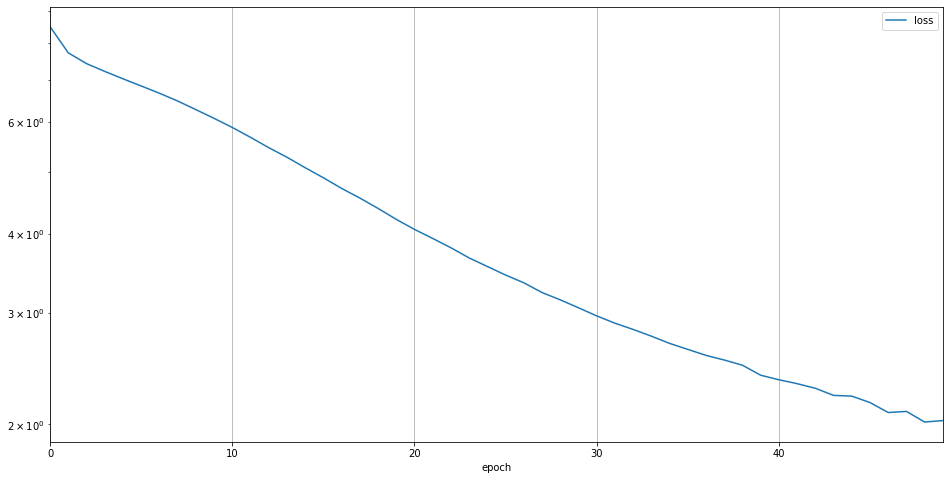

In [105]:
fig = plt.figure(figsize=(16, 8))
plot_history(history, metrics=['loss'], logy=True)

In [106]:
def RMSE(y_true_mixed, y_pred_mixed):
    value = 0
    for y_true, y_pred in zip(y_true_mixed, y_pred_mixed):
        y_true = y_true.reshape(-1).astype(float)
        y_pred = y_pred.reshape(-1).astype(float)
        value += K.mean(K.square(y_true)- K.square(y_pred))
    print(MSE(y_true, y_pred))
    return K.sqrt(value)

In [107]:
y_pred = model.predict(X_train)

In [109]:
float(RMSE(y_train, y_pred));

tf.Tensor(0.023453653041153016, shape=(), dtype=float64)
